# **<span style="color:#e76f51;">Training of EEG Signals For Schizophrenia Disorder using CNN</span>**

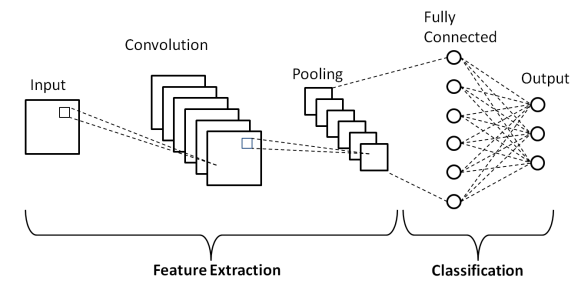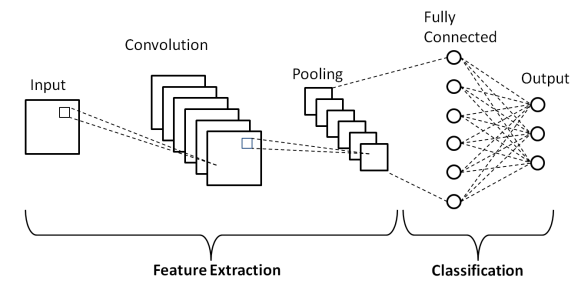

In [1]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api")
wandb.login(key=wandb_api_key)
    
wandb.init(project="Training of EEG Schizophrenia Disorder using CNN",name=f"15. Training-of-EEG-Schizophrenia-Disorder-Run-15")

ConnectionError: Connection error trying to communicate with service.

# **<span style="color:#e76f51;">Basic Lib Imports</span>**

In [ ]:
import os
import time
import numpy as np
import pandas as pd

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
    
! for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
       

In [ ]:
demographic = pd.read_csv("/kaggle/input/button-tone-sz/demographic.csv")
demographic

In [ ]:
demographic[" group"].value_counts()

In [ ]:
demographic[" group"].mean()

In [ ]:
for i, t in enumerate(list(demographic[" group"])):
    if t:
        print(f"{i} - Schizophrenia")
    else:
        print(f"{i} - HEALTHY")

In [ ]:
diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))
del demographic #deeting demographic Variable


In [ ]:
electrodes_list = list(pd.read_csv("/kaggle/input/button-tone-sz/columnLabels.csv").columns[4:])
print("Electrodes List \n",electrodes_list)

# **<span style="color:#e76f51;">Data PreProcessing</span>**

In [ ]:
def averaged_by_N_rows(a, n):
    """ 
    A function that averages n rows in a matrix
    """
    shape = a.shape
    assert len(shape) == 2
    assert shape[0] % n == 0
    b = a.reshape(shape[0] // n, n, 
                  shape[1])
    mean_vec = b.mean(axis=1)
    return mean_vec
    

In [ ]:
N_AVERAGED = 16
x_counter = 0
X = np.zeros((81 * 100,  9216 * len(electrodes_list) // N_AVERAGED), dtype="float32")
Y = np.zeros(len(X))

part1_path = "../input/button-tone-sz"
part2_path = "../input/buttontonesz2"


column_list = pd.read_csv("/kaggle/input/button-tone-sz/columnLabels.csv").columns
for person_number in tqdm(range(1, 81 + 1)):


    csv_path = f"{part1_path}/{person_number}.csv/{person_number}.csv"
    if not os.path.exists(csv_path):
        csv_path = f"{part2_path}/{person_number}.csv/{person_number}.csv"
    df = pd.read_csv(csv_path, 
                header=None,
                names=column_list)
    trials_list = set(df.trial)


    for t1, trial_number in enumerate(trials_list):
        number_of_trials = len(df[df.trial == trial_number])
        if number_of_trials == 9216.0:
            current_sample_matrix = df[df.trial == trial_number][electrodes_list].values
            averaged_by_N = averaged_by_N_rows(current_sample_matrix, n=N_AVERAGED)
            averaged_by_N_big_vec = averaged_by_N.reshape(-1)
            X[x_counter] = averaged_by_N_big_vec.astype(np.float32)
            Y[x_counter] = diagnosis_dict[person_number]
            x_counter += 1
print("Total trials with the Appropriate number of measurements - ", x_counter)
X = X[: x_counter]
Y = Y[: x_counter]
        
print("Total trials with the Appropriate number of measurements- ", x_counter)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_norm = (normalize(X.reshape(-1, 70), axis=0, norm='max')).reshape(X.shape)

In [ ]:
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X_norm, Y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
_norm = X

In [ ]:
X_train_2d = X_train_norm.reshape(X_train_norm.shape[0], len(electrodes_list), X_train_norm.shape[1] // len(electrodes_list), 1)
X_test_2d = X_test_norm.reshape(X_test_norm.shape[0], len(electrodes_list), X_test_norm.shape[1] // len(electrodes_list), 1)

In [ ]:
filepath="/kaggle/working/best_model1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 20),
                 activation='tanh',
                 input_shape=(X_train_2d.shape[1:])))
model.add(MaxPooling2D(pool_size=(5, 15)))

model.add(Conv2D(13, kernel_size=(3, 3),
                 activation='tanh',))
model.add(MaxPooling2D(pool_size=(3, 3)))
          

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(317, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.optimizers.Adam(0.0000075),
              metrics=['acc'])

In [ ]:
history_params = []

# **<span style="color:#e76f51;">Training Starts (Check 1)</span>**

In [ ]:
history = model.fit(X_train_2d, Y_train_norm,
          batch_size=256,
          epochs=400,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_2d, Y_test_norm), callbacks=[checkpoint,WandbCallback(validation_data=(X_test_2d, Y_test_norm))])

In [ ]:
wandb.finish()

## <span style="color:#e76f51;">Summarizing History For Accuracy For Convolutional Neural Networks</span>

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <span style="color:#e76f51;">Summarizing history for loss  For Convolutional Neural Networks</span></span>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
accuracy, loss = model.evaluate(X_test_2d, Y_test_norm)
print(f"Val accuracy={accuracy}  val loss={loss}")

In [ ]:
y_predicted =  model.predict(X_test_2d)

confusion_matr = confusion_matrix(Y_test_norm, np.round(model.predict(X_test_2d)))
confusion_matr

In [ ]:
print(
    "True Positive for schizophrenia ", confusion_matr[0, 0], "\n",
    "False Positive for schizophrenia ", confusion_matr[0, 1], "\n",
    "False Neagtive For Healthy ", confusion_matr[1, 0], "\n",
    "True Neagtive For Healthy ", confusion_matr[1, 1], "\n")

In [ ]:
TP = confusion_matr[0, 0]
FP = confusion_matr[0, 1]
FN = confusion_matr[1, 0]
TN = confusion_matr[1, 1]
TP, FP, FN, TN

### <span style="color:#e76f51;">Sensitivity for the first network</span>

In [ ]:
sensitivity = TP / (TP + FN)
sensitivity

### <span style="color:#e76f51;">Specificity for the first network</span>

In [ ]:
specificity = TN / (TN + FP)
specificity

### <span style="color:#e76f51;">Fully Connected Neural Network (Check 2 with tweeked parameters)</span>

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
filepath="/kaggle/working/best_model2.h5" # Checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# Simple Neural Networks with 5000 Neurons
model_2 = Sequential()




model_2.add(Conv2D(32, kernel_size=(5, 20),
                 activation='tanh',
                 input_shape=(X_train_2d.shape[1:])))
model_2.add(MaxPooling2D(pool_size=(5, 15)))

model_2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='tanh',))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
          

model_2.add(Dropout(0.15))
model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))

model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tf.optimizers.Adam(0.000005),
              metrics=['acc'])

In [ ]:
history_2 = model.fit(X_train_2d, Y_train_norm,
          batch_size=256,
          epochs=300,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_2d, Y_test_norm), callbacks=[checkpoint])

In [ ]:
loss, accuracy = model_2.evaluate(X_test_2d, Y_test_norm)
loss, accuracy 

## <span style="color:#e76f51;">Summarizing History For Accuracy And Loss For Second Network</span>

In [ ]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <span style="color:#e76f51;">Confusion matrix</span>

In [ ]:
y_predicted =  model_2.predict(X_test_2d)

confusion_matr = confusion_matrix(Y_test_norm, np.round(model_2.predict(X_test_2d)))
confusion_matr

In [ ]:
print(
 "True Positive for schizophrenia ", confusion_matr[0, 0], "\n",
 "False Positive for schizophrenia ", confusion_matr[0, 1], "\n",
 "False Neagtive For Healthy ", confusion_matr[1, 0], "\n",
 "True Neagtive For Healthy ", confusion_matr[1, 1], "\n"    
)

In [ ]:
TP = confusion_matr[0, 0]
FP = confusion_matr[0, 1]
FN = confusion_matr[1, 0]
TN = confusion_matr[1, 1]
TP, FP, FN, TN

### <span style="color:#e76f51;">Sensitivity for the Second network</span>

In [ ]:
sensitivity = TP / (TP + FN)
print(sensitivity)

### <span style="color:#e76f51;">Specificity for the Second network</span>

In [ ]:
specificity = TN / (TN + FP)
print(specificity)